In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image, ImageEnhance
import os
import csv
import base64
import requests
import json
from utils import *
import math
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.colors as mcolors
from helper_code.graph_reconstruction import *
from helper_code.mask_detection import *
from helper_code.metadata_extraction import *

In [19]:
## COLOR DETECTION
# basic
colors = {
    "black": (0, 0, 0),
    # "grey": (128, 128, 128),
    "white": (255, 255, 255),
    "red": (255, 0, 0),
    "purple": (255, 0, 255),
    "green": (0, 255, 0),
    "yellow": (255, 255, 0),
    "blue": (0, 0, 255),
    "pink": (255,20,147),
    "orange": (255, 165, 0),
}

# # paper - https://www.munsellcolourscienceforpainters.com/ColourSciencePapers/sRGBCentroidsForTheISCCNBSColourSystem.pdf
# colors = {
#     "pink": (231,141,170),
#     "red": (186,42,94),
#     "orange": (217,89,45),
#     "brown": (131,75,44),
#     "yellow": (215,182,74),
#     "green": (73,193,114),
#     "blue": (66,114,195),
#     "purple": (158,66,189),
#     "white": (231,225,233),
#     "black": (43,41,43),
# }

def get_norm_colors(graph_colors, onlyColorsInImage):
    
    final_colors_rgb = []
    final_colors_labels = []
    for c, rgb in colors.items():
        r, g, b = rgb
        if (onlyColorsInImage and c in graph_colors + ["white", "black"]) or not onlyColorsInImage:
            final_colors_rgb.append([r + .01, g + .01, b + .01])
            final_colors_labels.append(c)
    final_colors_rgb = np.array(final_colors_rgb)
    final_colors_labels = np.array(final_colors_labels)
    norm_colors_rgb = final_colors_rgb / np.linalg.norm(final_colors_rgb, axis=1, keepdims=True)
    
    return norm_colors_rgb, final_colors_labels

def predict_color(input_pixel, colors, labels):
    '''
    Function to predict the label of a new color
    '''
    # Normalize the new color
    norm_new_color = input_pixel / np.linalg.norm(input_pixel)
    norm_new_color = norm_new_color.reshape(1, -1)
    
    # Calculate cosine similarities
    similarities = cosine_similarity(norm_new_color, colors)[0]
    
    # Find the index of the most similar color
    most_similar_index = np.argmax(similarities)
    
    # Return the label of the most similar color
    return labels[most_similar_index]

# def is_gray_pixel(pixel, tolerance=10):
#     """
#     Check if a pixel is gray.
    
#     Args:
#     pixel (tuple): A tuple representing the RGB values of the pixel (R, G, B).
#     tolerance (int): The tolerance level for considering a pixel as gray.
    
#     Returns:
#     bool: True if the pixel is gray, False otherwise.
#     """
#     r, g, b = pixel
#     return abs(r - g) < tolerance and abs(r - b) < tolerance and  abs(g - b) < tolerance 

def is_gray_pixel(pixel, tolerance=10):
    """
    Check if a pixel is gray.
    
    Args:
    pixel (tuple): A tuple representing the RGB values of the pixel (R, G, B).
    tolerance (int): The tolerance level for considering a pixel as gray.
    
    Returns:
    bool: True if the pixel is gray, False otherwise.
    """
    print(pixel)
    maximum = 255
    r, g, b = pixel
    R = r/maximum
    G = g/maximum
    B = b/maximum
    Cmax = max(R, G, B) 
    Cmin = min(R, G, B) 
    delta = Cmax - Cmin
    return delta == tolerance

def distance(a,b):
    dx = a[0]-b[0]
    dy = a[1]-b[1]
    dz = a[2]-b[2]
    dist = math.sqrt(dx*dx+dy*dy+dz*dz)
    return dist

def get_nearest_color(input_pixel):
    mn = 999999
    color = ''
    p1, p2, p3 = input_pixel
    for name in colors:
        rgb = colors[name]
        d = distance((p1, p2, p3), rgb)
        if d < mn:
            mn = d
            color = name
    return color

def get_nearest_color_within_colors(input_pixel, graph_colors):
    mn = 999999
    color = ''
    p1, p2, p3 = input_pixel
    for name in graph_colors + ["white", "black"]:
        if name in colors:
            rgb = colors[name]
            d = distance((p1, p2, p3), rgb)
            if d < mn:
                mn = d
                color = name
    return color

def get_nearest_color(pixel):
    r, g, b = pixel
    grey = min(r, g, b)

    newR = r - grey
    newG = g - grey
    newB = b - grey

    if newR + newG + newB == 0: return "black"
    pctRed = newR / (newR + newG + newB)
    pctBlue = newB / (newR + newG + newB)
    pctGreen = newG / (newR + newG + newB)

    pctGrey = grey / 255

    # How to distinguish between red and pink?
    if pctRed > 0.5:
        if pctGrey > 0.5:
            return "pink"
        else:
            return "red"
    elif pctGreen > 0.5:
        return "green"
    elif pctBlue > 0.5:
        return "blue"
    elif pctGreen < 0.2:
        return "purple"
    elif pctBlue < 0.2:
        return "yellow"
    elif pctRed < 0.2:
        return "teal"
    elif pctGrey > 0.9:
        return "white"
    elif pctGrey < 0.1:
        return "black"
    
    return "grey"

def get_points_new(boundingBox, image_name, color, rgb_colors, wBox, hBox, x_axis, y_axis):

    graph = []
    image = Image.open(image_name)
    image = image.convert('RGB')
    filter = ImageEnhance.Contrast(image)
    image = filter.enhance(2)


    width, height = image.size
    mask = np.zeros((width, height))

    for y in range(0, height):
        for x in range(0, width):

            r, g, b = image.getpixel((x, y))

            new_color = get_nearest_color([r, g, b])
            
            if new_color == color:
                mask[x, y] = 1

    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):
            
            x, y = get_middle_coordinate(x0, y0, wBox, hBox)
            value = get_filtered_answer(mask, x0, y0, wBox, hBox, boundingBox["bottomRight"][0], boundingBox["bottomRight"][1])

            if value: 
                graph.append({
                "topLeft": (x0, y0), 
                "middle": convertPoint((x,y), boundingBox, width, height, x_axis, y_axis), 
                })
    
    return graph

def get_points(boundingBox, image_name, color, rgb_colors, norm_colors, labels, wBox, hBox, x_axis, y_axis, onlyColorsInImage, distance_type):

    graph = []
    image = Image.open(image_name)
    image = image.convert('RGB')

    width, height = image.size
    mask = np.zeros((width, height))

    for y in range(0, height):
        for x in range(0, width):

            r, g, b = image.getpixel((x, y))

            if (color == "gray" or color == "grey") and is_gray_pixel([r, g, b], tolerance=10):
                new_color = color
            elif distance_type == "euclidean":
                new_color = get_nearest_color_within_colors((r,g,b), rgb_colors) if onlyColorsInImage else get_nearest_color((r,g,b)) 
            else:
                new_color = predict_color(np.array([r + .01, g + .01, b + .01]), norm_colors, labels)

            if new_color == color:
                mask[x, y] = 1

    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):
            
            x, y = get_middle_coordinate(x0, y0, wBox, hBox)
            value = get_filtered_answer(mask, x0, y0, wBox, hBox, boundingBox["bottomRight"][0], boundingBox["bottomRight"][1])

            if value: 
                graph.append({
                "topLeft": (x0, y0), 
                "middle": convertPoint((x,y), boundingBox, width, height, x_axis, y_axis), 
                })
    
    return graph

In [20]:
## HELPER FUNCTION
def is_valid_color(color):
    try:
        mcolors.to_rgba(color)
        return True
    except ValueError:
        return False

In [24]:
def do_analysis(image_number, predictor):
    image_name = '../plot_images/'+str(image_number)+'.png'
    image = cv2.imread(image_name)

    height, width = image.shape[:2]
    input_point = np.array([[width // 2 - 50, height // 2 - 50], [width // 2 - 50, height // 2 + 50], [width // 2 + 50, height // 2 - 50], [width // 2 + 50, height // 2 + 50]])
    input_label = np.array([1, 1, 1, 1])

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
    main_mask, main_mask_score = get_main_mask(masks, scores)

    n_image = image.copy()
    new_image, boundingBox = get_bounding_box(main_mask, n_image)

    points = np.array([
        boundingBox["topLeft"], 
        [boundingBox["topLeft"][0], boundingBox["bottomRight"][1]], 
        [boundingBox["bottomRight"][0], boundingBox["topLeft"][1]], 
        boundingBox["bottomRight"]
    ])
    
    return image_name, boundingBox

In [22]:
def do_complete_analysis(image_number, wBox, hBox, metadata, image_name, boundingBox, onlyColorsInImage = False, distance_type = "euclidean"):

    x_axis = metadata["x-axis"]["range"]
    y_axis = metadata["y-axis"]["range"]
    x_axis_title = metadata["x-axis"]["title"]
    y_axis_title = metadata["y-axis"]["title"]

    axis_labels = []
    rgb_colors = []
    coordinates = []
    for label, color in metadata["types"]:
        axis_labels.append(label)
        rgb_colors.append(color)
    
    # norm_colors_rgb, final_colors_labels = get_norm_colors(rgb_colors, onlyColorsInImage)

    for color in rgb_colors:
        # coordinates.append(get_points(boundingBox, image_name, color, rgb_colors, norm_colors_rgb, final_colors_labels, wBox, hBox, x_axis, y_axis, onlyColorsInImage, distance_type))
        coordinates.append(get_points_new(boundingBox, image_name, color, rgb_colors, wBox, hBox, x_axis, y_axis))

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_axis, y_axis

In [9]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

IMAGE NUMBER 1


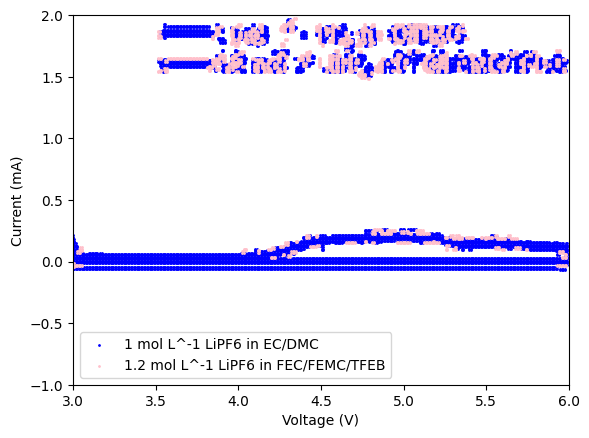

IMAGE NUMBER 2


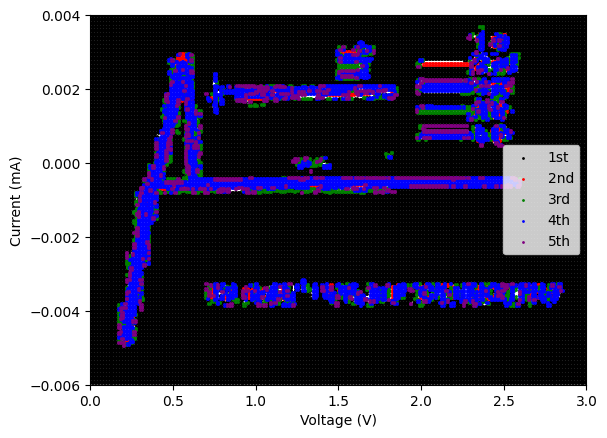

IMAGE NUMBER 3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


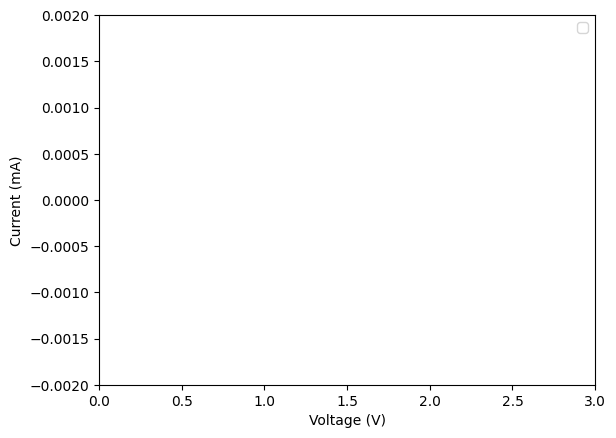

IMAGE NUMBER 4


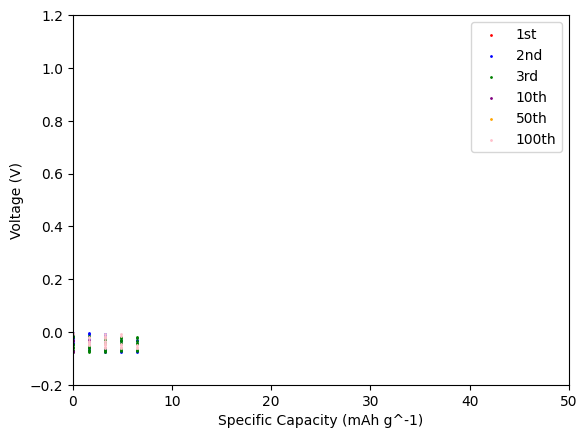

IMAGE NUMBER 5


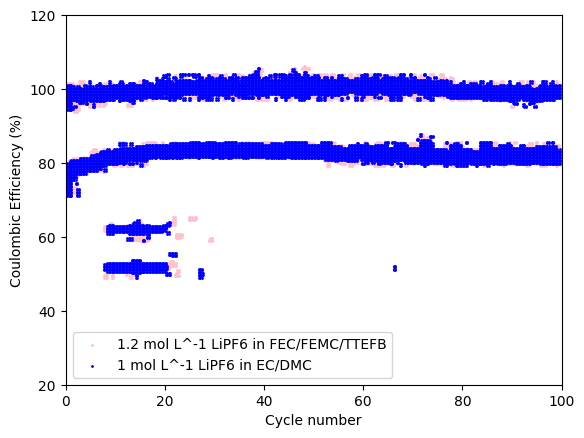

IMAGE NUMBER 6


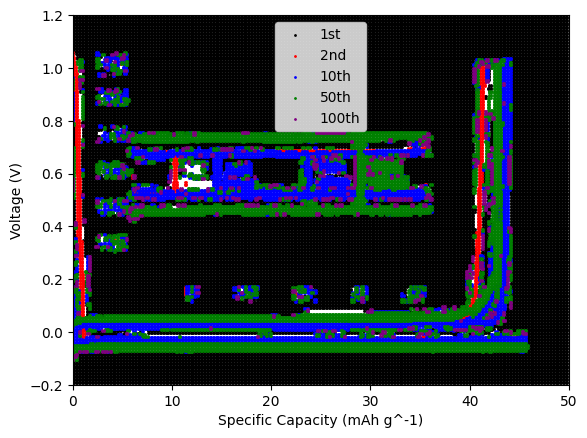

IMAGE NUMBER 7


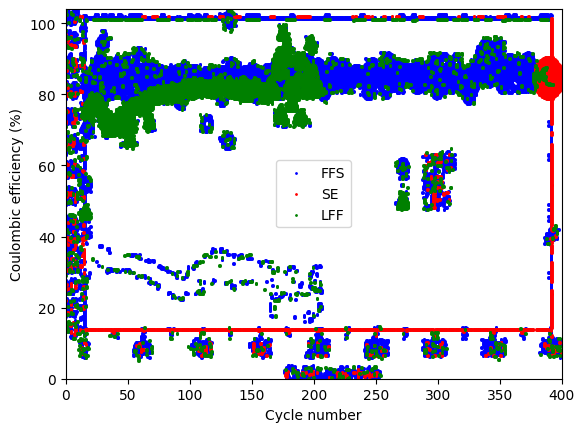

IMAGE NUMBER 8


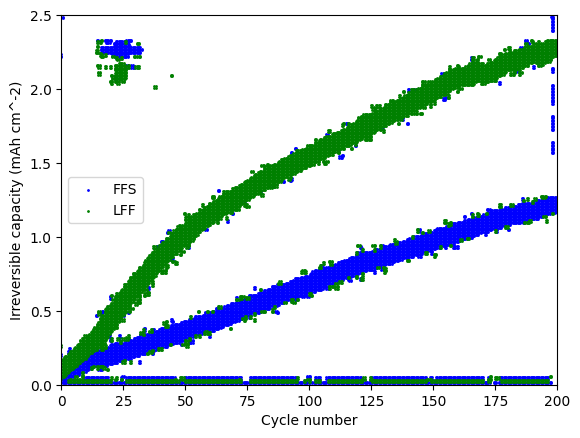

IMAGE NUMBER 9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


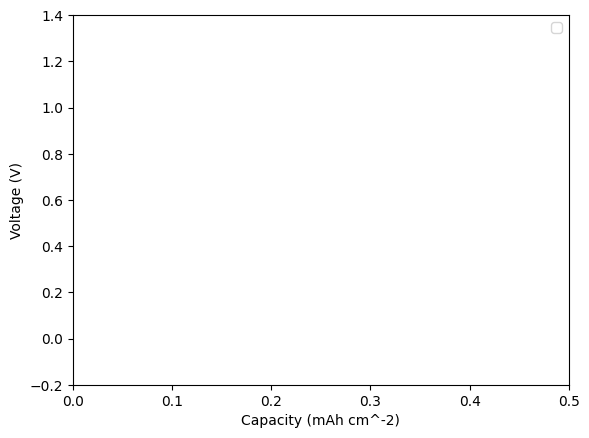

IMAGE NUMBER 10


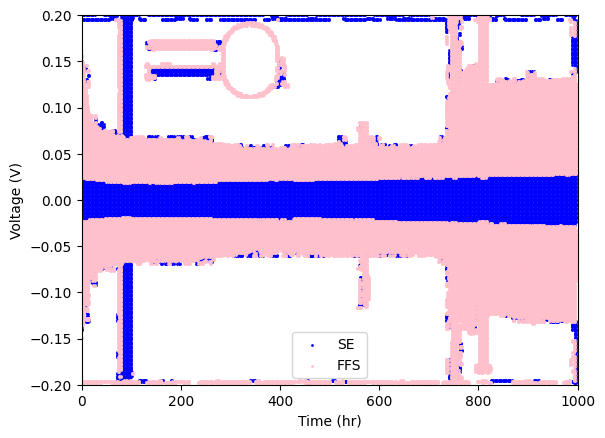

IMAGE NUMBER 11


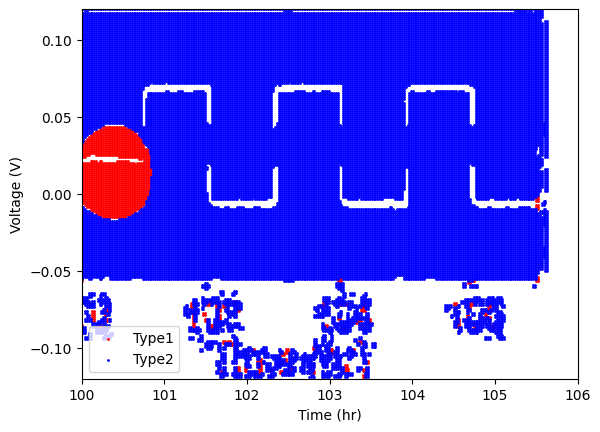

IMAGE NUMBER 12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


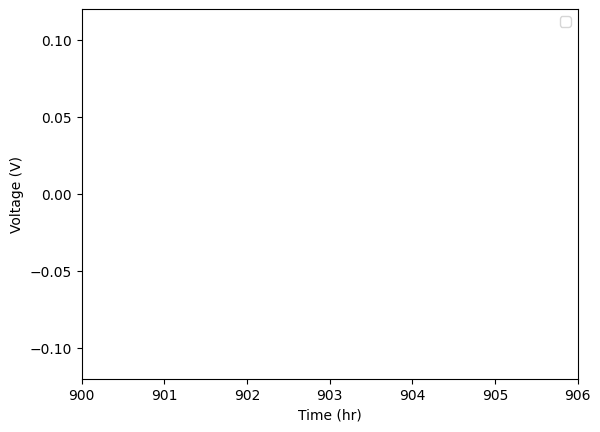

IMAGE NUMBER 13


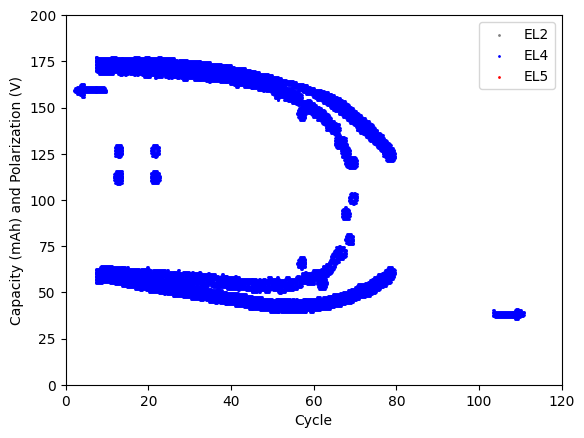

IMAGE NUMBER 14


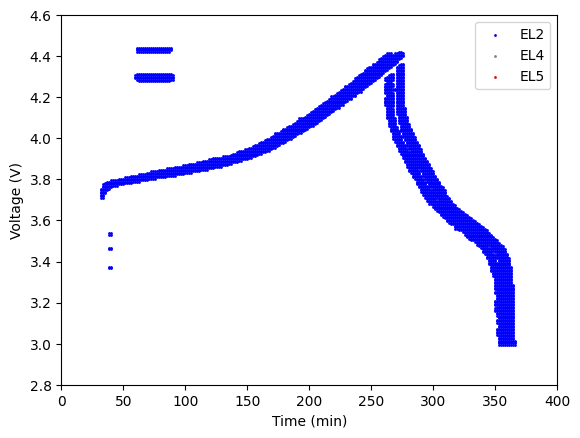

IMAGE NUMBER 15


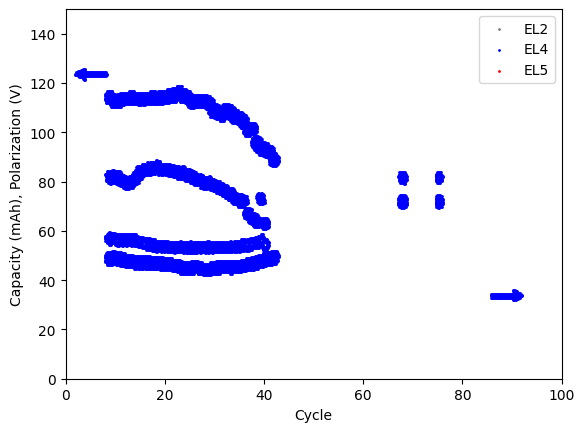

IMAGE NUMBER 16


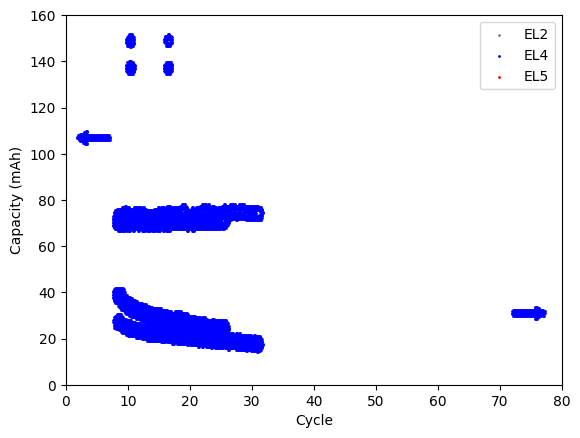

IMAGE NUMBER 17


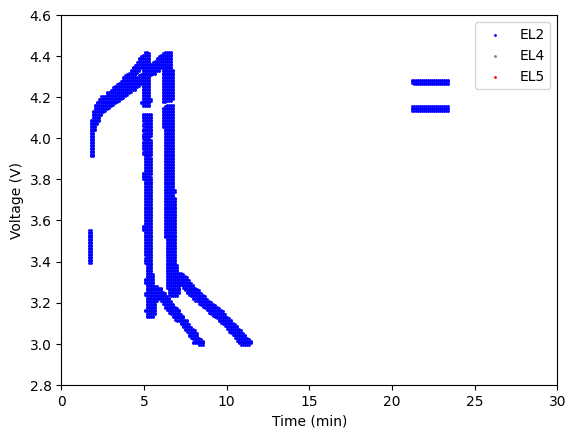

IMAGE NUMBER 18


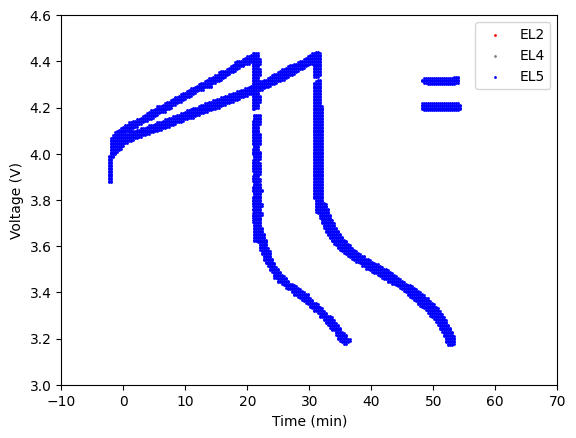

IMAGE NUMBER 19


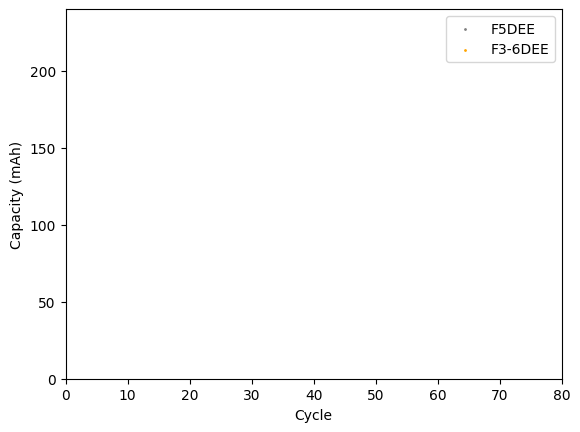

IMAGE NUMBER 20


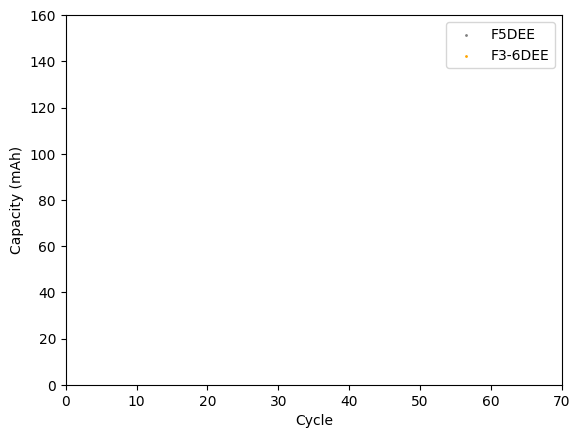

IMAGE NUMBER 21


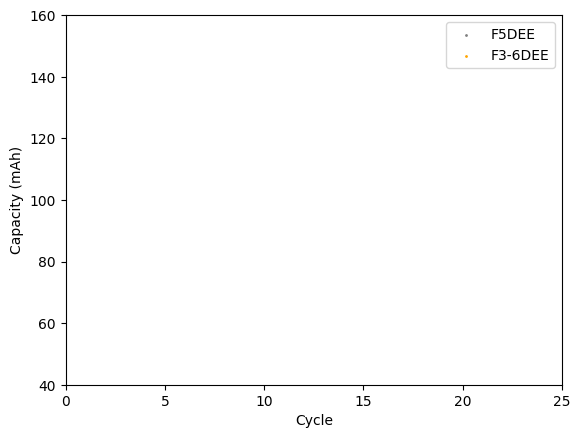

IMAGE NUMBER 22


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt

for image_num in range(1, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num, predictor)

    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range = do_complete_analysis(image_num, 1, 1, prompt, image_name, boundingBox, True)

    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()    

IMAGE NUMBER 1


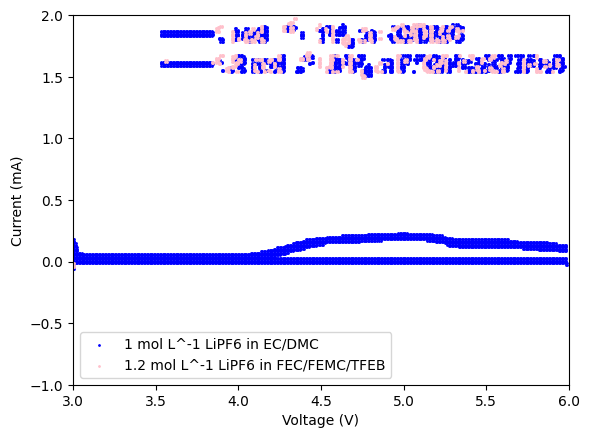

IMAGE NUMBER 2


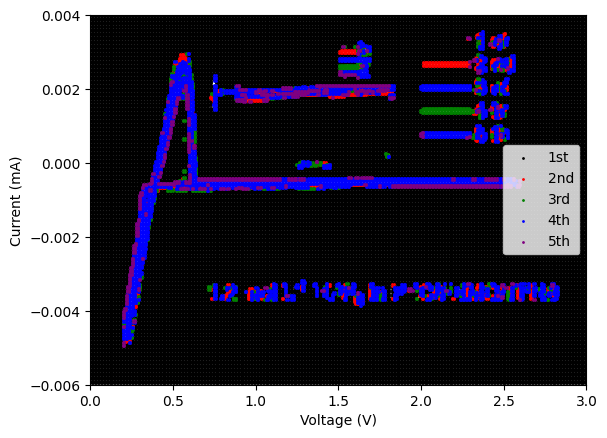

IMAGE NUMBER 3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


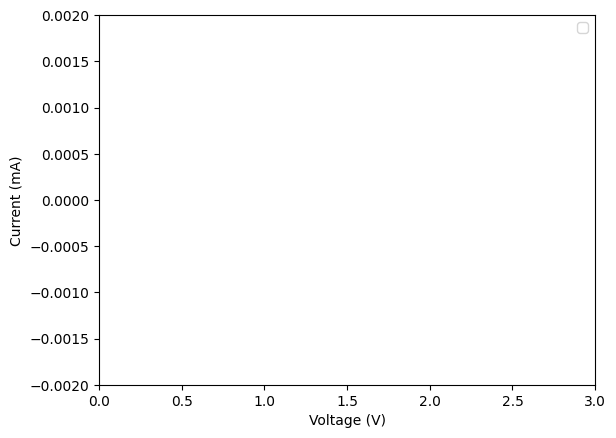

IMAGE NUMBER 4


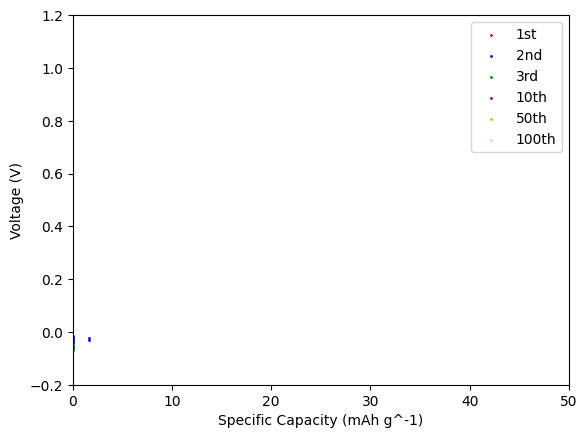

IMAGE NUMBER 5


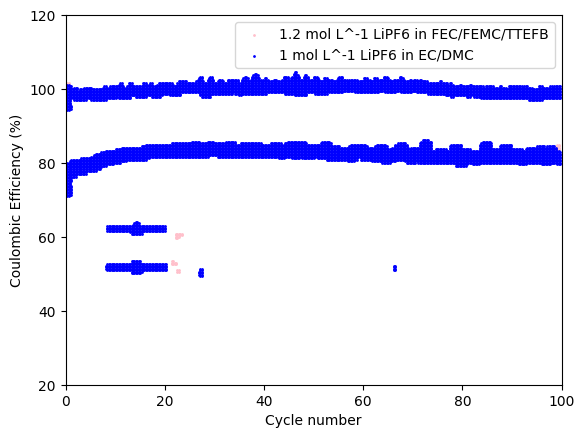

IMAGE NUMBER 6


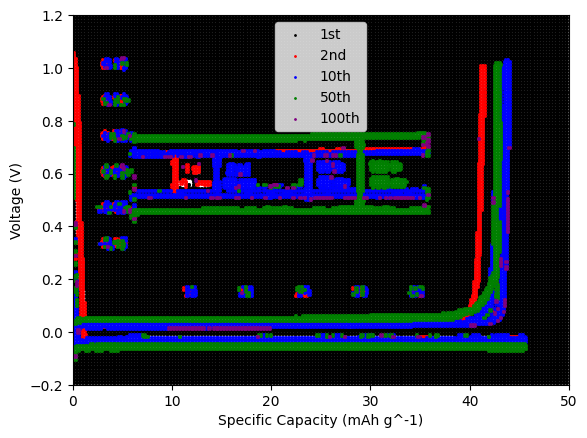

IMAGE NUMBER 7


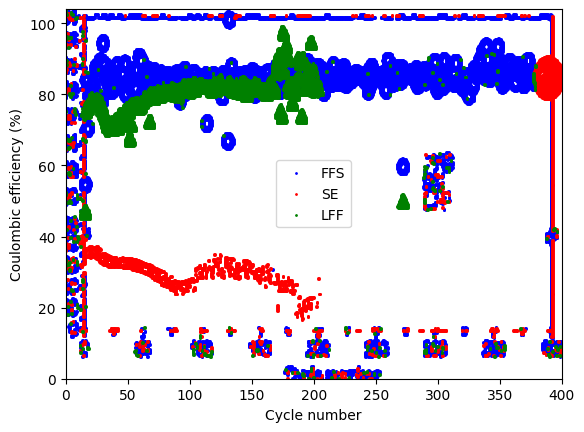

IMAGE NUMBER 8


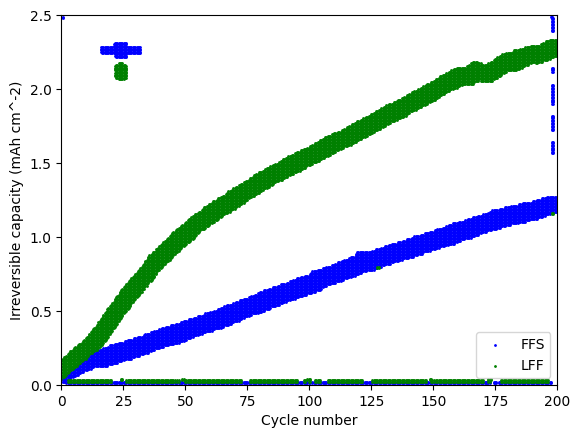

IMAGE NUMBER 9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


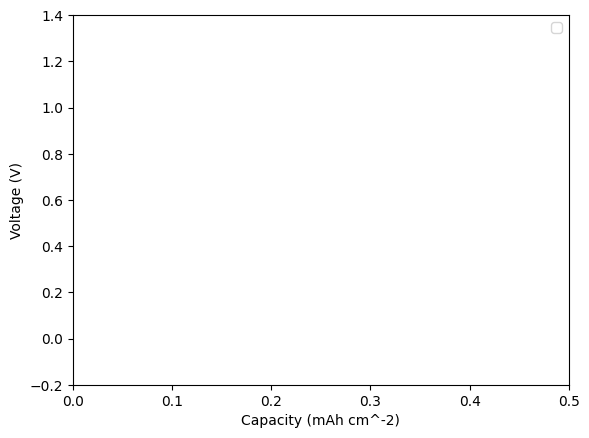

IMAGE NUMBER 10


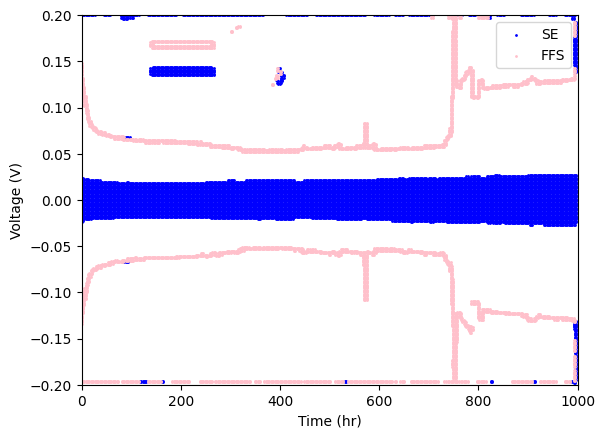

IMAGE NUMBER 11


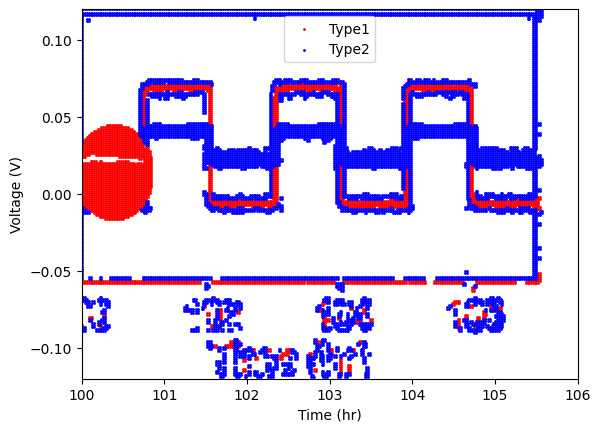

IMAGE NUMBER 12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


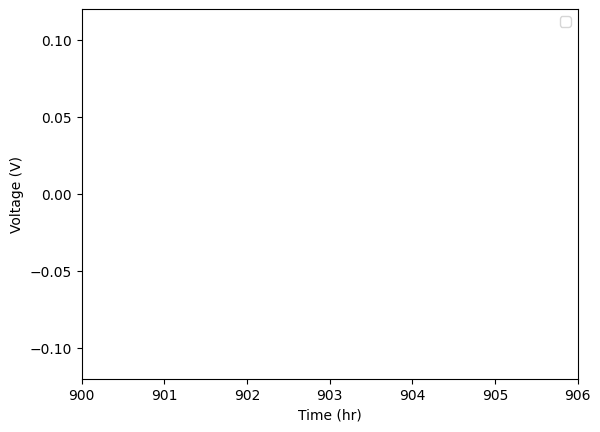

IMAGE NUMBER 13


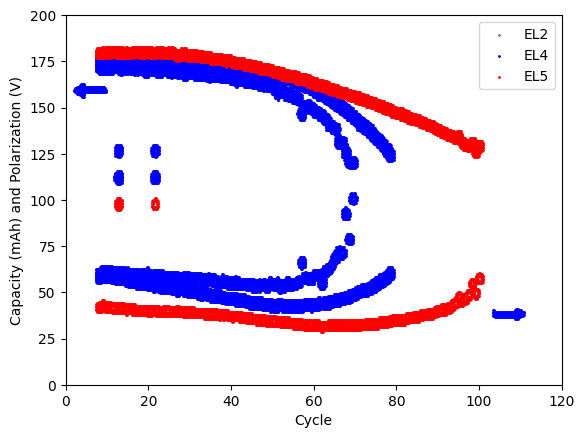

IMAGE NUMBER 14


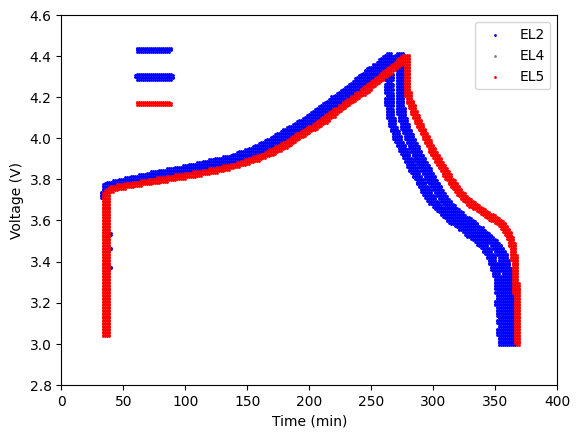

IMAGE NUMBER 15


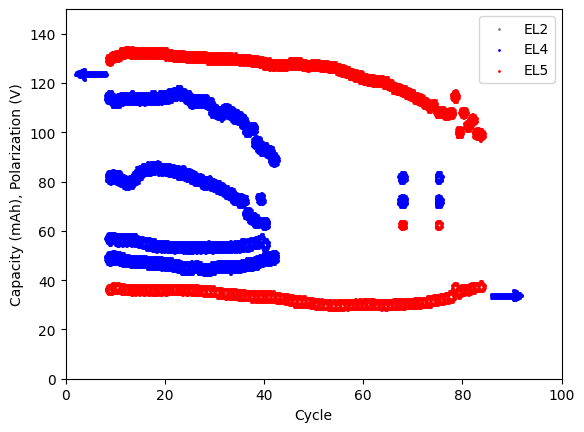

IMAGE NUMBER 16


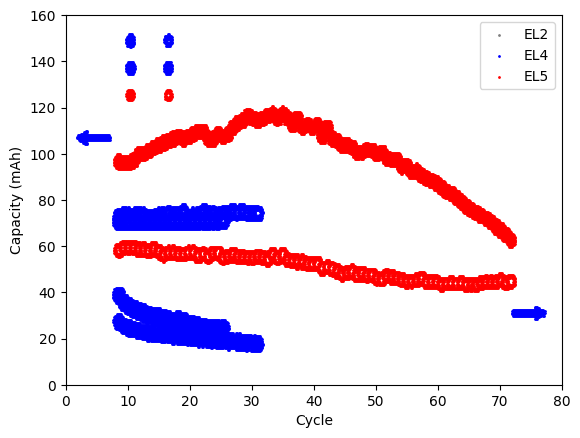

IMAGE NUMBER 17


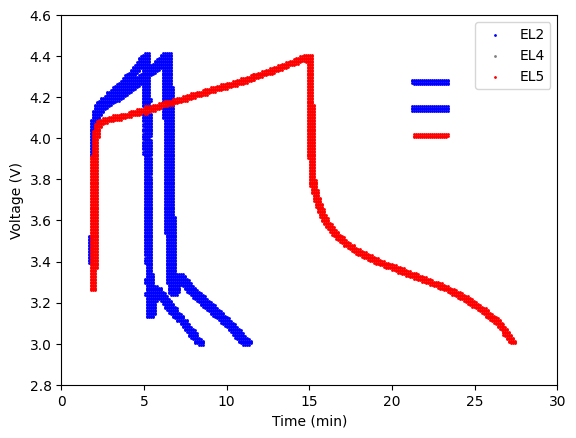

IMAGE NUMBER 18


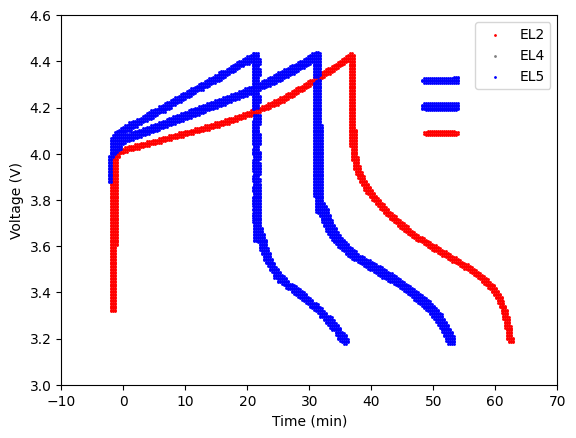

IMAGE NUMBER 19


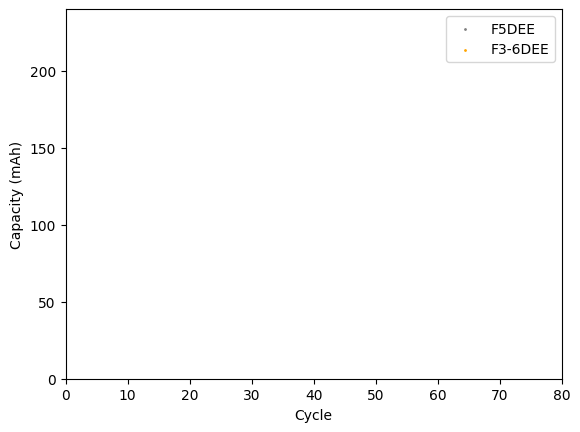

IMAGE NUMBER 20


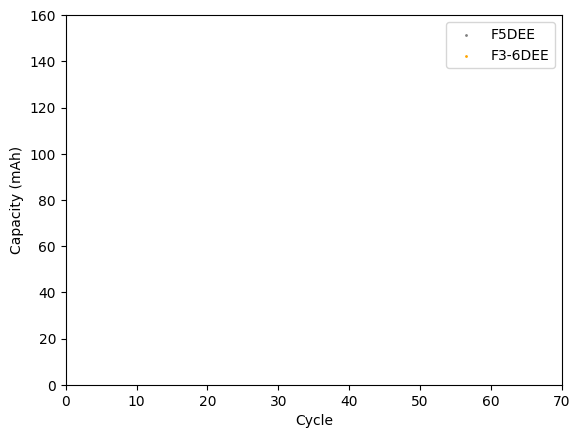

IMAGE NUMBER 21


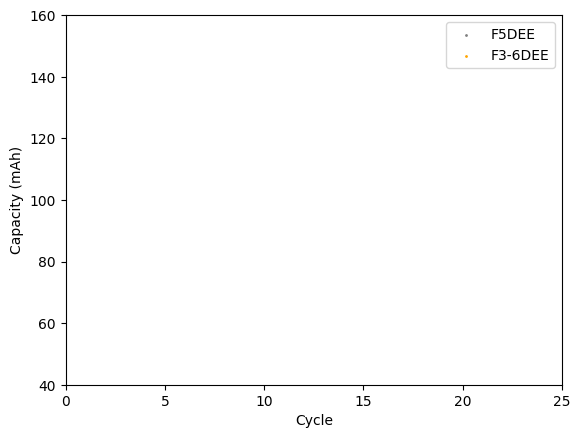

IMAGE NUMBER 22


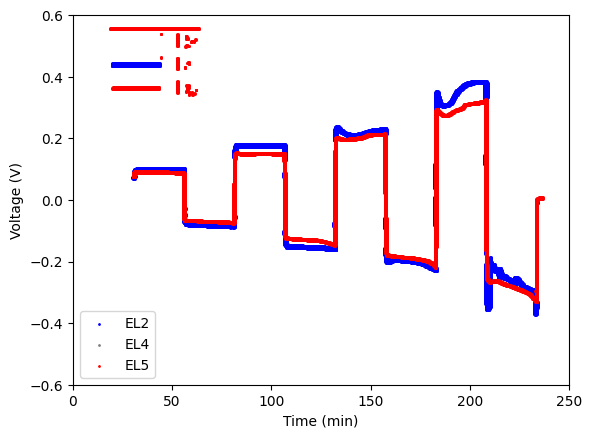

IMAGE NUMBER 23


KeyboardInterrupt: 

In [25]:
for image_num in range(1, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(str(image_num), predictor)
    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range = do_complete_analysis(image_num, 1, 1, prompt, image_name, boundingBox, True)

    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()   